Creative Commons CC BY 4.0 Lynd Bacon & Associates, Ltd. Not warranted to be suitable for any particular purpose. (You're on your own!)

# Classification and Regression Trees

There are many different algorithms that use tree-structured partitionings of features to predict target variable values.  They include:  

* CART
* C 5.0
* Random Forest (an _ensemble_ method)
* CHAID ($\chi^2$ interaction detection)
* Various boosting implmentations

## CART 

CART "trains" by recursively partitioning, or splitting the data in a sequence of steps that each attempts to best explain, or discriminate between, target variable labels.  It can be used for regression and for classification problems. In the case of the latter, CART can be used to predict k labels, where k $\ge$ 2. 

It is a _greedy algorithm_: it attempts to optimize predictive accuracy binary split by split, rather than on an overall basis.  As a result, it may not find the best, or optimal, tree.  Classifier tree splits are determined based on the resulting quality of the results of the split based on a measure of homogeneity, [_Gini Impurity_](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity), or in terms of [entropy](https://en.wikipedia.org/wiki/Entropy#Information_theory). The utility of regression tree splits are measured in terms of mean squared predictor error, and variations on it.


CART requires making few assumptions about the data.  It tends to overfit.  Overfitting can be mitigated by regularization using hyperparameters that limit tree size, minimum size of the result of a split, the number of features used for splitting, and the final number of distinct partitions of the data.

A CART model can be _examined_:  it can be represented as a hierarchy of "if then" rules.  It's not "black box."

CART and other tree models have some specific terminology:

* A partition is called a _node_;
* Splits result in _branches_ that lead to new, smaller nodes that descend from "parent" nodes;
* The final nodes are sometimes called _leaves_.
* The pre-split data is usually called the _root_ node.

This terminology becomes more clear when looking 

The CART algorithm was originally described by [Breiman, Freedman, Stone & Olshen (1984)](https://www.amazon.com/Classification-Regression-Wadsworth-Statistics-Probability/dp/0412048418). 

Let's give using CART on the cervical CA data a try.

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, Markdown
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import linear_model
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
import pickle
import os
import shelve
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
%matplotlib inline


# Getting the Data

Let's get the data in that `shelve` database. 

Assuming they are in the data subdirectory of the current pwd: (Adjust as necessary)

In [3]:
with shelve.open('DATA/ML/cervical') as sdb:
    cervical=sdb['cervical']  # this should be aPandas DataFrame
    cervical2=sdb['cervical2']  # this should be, too

In [3]:
X=cervical2.iloc[:,1:].to_numpy()
y=cervical2.iloc[:,0].to_numpy()
feat_nams=cervical2.columns.to_list()[1:]

# CART Classifier

Here we're using the [scikit-learn DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier):

In [4]:
cTree=DecisionTreeClassifier(max_depth=2,
                             min_samples_leaf=20,
                             min_samples_split=50)
tree_clf1=cTree.fit(X,y)

In [5]:
# export to dot file, use the dot program to create a png file.
export_graphviz(
    tree_clf1,
     out_file='cTree4.dot',  #doesn't seem to overwrite by default
    feature_names=feat_nams,
    rounded=True,
    filled=True
)

After exporting the dot file, it is converted to a png file using the dot program from the command prompt. Then the png is inserted into this Notebook:

![cTree](cTree4.png)

## CART Predictions, etc.

Predictions can be obtained from either type of CART model.  Here we'll examine the predictions the classifier above produces.

In [6]:
cervPred=tree_clf1.predict(X)
cervPredProb=tree_clf1.predict_proba(X)

## Accuracy, AUC

In [7]:
print("CART accuracy: {:5.3f} AUC: {:5.3f}".format(
        accuracy_score(y,cervPred),
        roc_auc_score(y,cervPredProb[:,1]))
     )

CART accuracy: 0.932 AUC: 0.600


# Precision and Recall

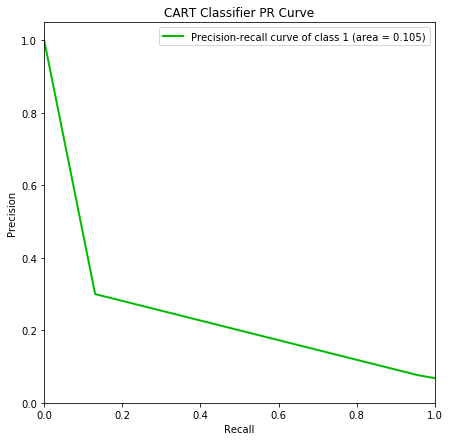

In [8]:
skplt.metrics.plot_precision_recall(y, cervPredProb,
        plot_micro=False,
        figsize=(7,7),
        classes_to_plot=1,
        title='CART Classifier PR Curve');

**Question**:  Why do you think there's an "elbow" in the above Precision/Recall graph?

# UDU: Grid Search and CV for Better CARTing

There are tools in other (non-Python) environments for "pruning" CART trees so as to reduce overfitting.  Another way of getting a good CART model is by doing a grid search over tree parameters.  Try that here.  The following code will give you a start.  Give at go at manipulating the parameter values that are searched.  Try adding additional parameters with values to search over.

Did your results produce anything really useful?

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

Here are the parameters that values can be searched for:

In [10]:
treeclf=DecisionTreeClassifier(criterion='entropy',random_state=99)
print("Tree Parameters:")
treeclf.get_params().keys()

Tree Parameters:


dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [11]:
param_grid={'max_depth':[2,3,4],'min_samples_leaf':[10,20],
            'max_features':[3,5,7]}
grid=GridSearchCV(treeclf,param_grid=param_grid,cv=20)
grid.fit(X_train,y_train)

/home/lynd/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=20, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=99,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [2, 3, 4], 'max_features': [3, 5, 7],
                         'min_samples_leaf': [10, 20]},
  

In [12]:
print("Best cross-validation accuracy: {:.4f}".format(grid.best_score_))
print("Test set score: {:.4f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.9270
Test set score: 0.9467
Best parameters: {'max_depth': 2, 'max_features': 3, 'min_samples_leaf': 10}


In [112]:
# Use the following to examine cv_results. 

# pd.DataFrame(grid.cv_results_)

## "Best" Tree Based On Grid Search  

Assuming that you get a "best" tree that is really any better than any other tree, of course.

\*\*grid_best_params_, below, is a dict of parameter key value pairs.  It should be like the dict that's output, above.

In [15]:
# Get the best tree based on the search

bestTree=DecisionTreeClassifier(**grid.best_params_)  

# Fit this tree using the training data

bestTreeFit=bestTree.fit(X_train,y_train)

## Feature Importances

Importance here is a normalized measure of the extent to which splits based on a feature reduce the fitting criterion, either _gini impurity_ or _entropy_. 

Your results will vary.

In [16]:
bestTree.feature_importances_ 

array([0.64038214, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.35961786])